# ER/NR Band Discrimination

In [22]:
!rm -Rf ~/.cache ./pax_*

import logging
logging.getLogger('rootpy.stl').setLevel(logging.CRITICAL)
logging.getLogger('hax').setLevel(logging.CRITICAL)
logging.getLogger('requests').setLevel(logging.CRITICAL)
logging.getLogger('ROOT').setLevel(logging.CRITICAL)
logging.basicConfig(level=logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

In [23]:
# Set name of notebook for folder to save plots in
notebook_name = 'Xe1T_BandStuff'

# run imports
%run "../helpers/initialize_midway.ipynb"

# get all plotfunctions
%run "../helpers/plot_functions.ipynb"

Initialization done, Notebook was last run on: 19/08/2017


In [24]:
hax.misc.code_hider()

In [25]:
# Initialize pax/hax

pax_version = '6.6.5'

# pax configuration
from pax import units, configuration, datastructure
pax_config = configuration.load_configuration('XENON1T')
tpc_radius = pax_config['DEFAULT']['tpc_radius']
tpc_height = pax_config['DEFAULT']['tpc_length']

# hax configuration
import hax
from lax.lichen import Lichen, RangeLichen, ManyLichen, StringLichen
from lax import __version__ as lax_version

hax.init(minitree_paths = ['/home/danielfm/',
                         '/scratch/midway2/berget2/minitrees/',
                         '/scratch/midway2/breur/miniforest/',
                         '/project/lgrandi/xenon1t/minitrees/pax_v' + pax_version+'/',
                           '/project2/lgrandi/xenon1t/minitrees/pax_v' + pax_version+'/'],  
         pax_version_policy = pax_version, make_minitrees = False)

In [26]:
# Parse Datasets
dsets = hax.runs.datasets

# select the latest versions
dsets = dsets[(dsets.pax_version == '6.6.5')]

# Select tags 
dsets = hax.runs.tags_selection(dsets, include=['sciencerun1'], exclude=['MVoff,blinded', 'NG,MVoff', 'Noise', 
       'blinded,MVoff', 'blinded,earthquake', 'blinded,flash',
       'blinded,messy,PMTtrip,MVoff,flash', 'blinded,messy,flash', 'messy',
       'messy,flash', 'messy,flash,pmttrip', 'messy,pmttrip,flash',
       'messy,pmttrip,flash,ramping', 'noise', 'test', 'trip,messy'])

# Select with a processed location
dsets = dsets[(dsets.location != '')]
print('We start with %i processed SR1 datasets' % len(dsets))

dsets_list = []
sources = ['Rn220','AmBe','neutron_generator']
for i, source in enumerate(sources):
    dsets_list.append(dsets[(dsets.source__type == source) ])
    print('%s Datasets: %i' % (source, len(dsets_list[i])) )

We start with 3142 processed SR1 datasets
Rn220 Datasets: 238
AmBe Datasets: 334
neutron_generator Datasets: 47


In [27]:
dfs = []
for i, source in enumerate(sources):
    dfs.append(hax.minitrees.load(dsets_list[i].name, 
                                  treemakers=['Corrections','Basics','Extended','Fundamentals', 'TotalProperties', 'Proximity', 'TailCut'], 
                                  preselection = 'cs1<500', num_workers=20))

In [28]:
import lax
lax_version = lax.__version__
from lax.lichens import sciencerun1

# get low energy er/nr cuts
cut_list = [sciencerun1.LowEnergyRn220(), sciencerun1.LowEnergyAmBe(), sciencerun1.LowEnergyNG()]

In [29]:
excluded_cuts = ['CutS1LowEnergyRange']
for i in range(len(dfs)):
    print('%s Source Cut Summary:' % sources[i])
    dfs[i] = cut_list[i].process(dfs[i])
    for cut_name in cut_list[i].get_cut_names():
        if cut_name in excluded_cuts:
            continue
        else:
            dfs[i] = cuts.selection(dfs[i], dfs[i][cut_name], desc=cut_name)
    dfs[i] = cuts.below(dfs[i], 's1_range_50p_area', 400, desc='s1Width400')
    cuts.history(dfs[i])
    print('\n')
 

Rn220 Source Cut Summary:


ValueError: cannot set a frame with no defined index and a scalar

In [31]:
#consts for CES
g2=11.463   # pe/e-
g1=0.1471 # pe/ph
w_value=0.0137

for i in range(len(dfs)):
    dfs[i]["CES"] = (dfs[i].cs2_bottom/g2 + dfs[i].cs1/g1)*w_value
    dfs[i]["DISC"] = np.log10(dfs[i].cs2_bottom/dfs[i].cs1)

AttributeError: 'DataFrame' object has no attribute 'cs2_bottom'

### Recoil Bands, ER Discrimination, and Leakage

In [32]:

fig = plt.figure(figsize = (16,10))

for i in range(len(dfs)):
    plt.plot(dfs[i].cs1, np.log10(dfs[i].cs2_bottom/dfs[i].cs1),'o',label=sources[i],alpha=0.3,markersize=4)
    
plt.xlim(0,500)
plt.xlabel('cs1 (PE)')
plt.ylabel('log10(cs2_bottom/cs1)')
plt.title('Recoil Bands, Low Energy Source Cuts')
plt.legend(markerscale=3)

plt.show()

AttributeError: 'DataFrame' object has no attribute 'cs1'

In [33]:
# Develop ER Discrimination Line

df_rn = dfs[0]

cs1_lim, cs1_width = 200, 10
cs1_bins = int(cs1_lim/cs1_width)
hist_range, hist_bins = [0,3], 50
hist_width = (hist_range[1]-hist_range[0])/hist_bins

fig = plt.figure(figsize = (12*5,6*4))
er_disc = []

for i in range(cs1_bins):
        
    # slice data in cs1
    cs1_min, cs1_max = i*cs1_width, (i+1)*cs1_width
    df = cuts.selection(df_rn, (df_rn['cs1'] > cs1_min) & (df_rn['cs1'] <= cs1_max), desc='cs1Slice', quiet=True)
    
    
    # fill and fit discrimination hist
    
    x = df.DISC
    mean = np.mean(x)
    i_mean = int((mean/hist_width)+0.5)
    std = np.std(x)
    i_std = int((std/hist_width)+0.5)
    i_min, i_max = max(i_mean-3*i_std,0), min(i_mean+3*i_std,hist_bins)
    
    plt.subplot(4,5,i+1)
    ax = plt.gca()
    
    n, bins, patches = plt.hist(x, bins=hist_bins, range=hist_range)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    x_fit = bin_centers[i_min:i_max]
    y_fit = n[i_min:i_max]
    guess = (mean, std, max(y_fit))
    popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=guess)
    fit = gaussian(x_fit, *popt)
    perr = np.sqrt(np.diag(pcov))
    chi2, ndf = chisquare_ndf(y_fit,fit)
    
    s = ('$\mu$ = %.4f $\pm$ %.4f  \n$\sigma$ = %.4f $\pm$ %.4f \n$\chi ^2$/ndf = %.1f / %i' 
         % (popt[0], perr[0], popt[1], perr[1], chi2, ndf))
    bbox_props = dict(boxstyle="Round,pad=0.5", fc="gray", ec="blue", lw=2, alpha = 0.5)
    plt.text(0.1, 0.5, s,  transform=ax.transAxes, bbox=bbox_props, size=18)
    x_plot = np.linspace(mean-3*std,mean+3*std,50)
    y_plot = gaussian(x_plot, *popt)
    plt.plot(x_plot, y_plot, c='k', linewidth=3, linestyle='dashed')
    plt.xlabel('log10(cs2_bottom/cs1)', fontsize=18)
    plt.title('Rn220 cS1 Slice: %i PE < cS1 <= %i PE' % (cs1_min,cs1_max), fontsize=20)
        
    er_disc.append([np.mean([cs1_min,cs1_max]),popt[0],popt[1]])
    
er_disc = np.array(er_disc)

plt.suptitle('ER Band Discrimination Distribution Fits', fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

KeyError: 'cs1'

In [34]:
# Discrimination line
def disc_exp(cs1, p0, p1, p2, p3):
    return np.exp(p0+p1*cs1) + p2 + p3*cs1

# popt for SR0 99%
sr0_99_popt = (-0.645351,-0.0544212,1.52071,-0.00108844)

# Discrimination parameters for specific exclusion
def disc_popt(er_disc, sigmas):
    x = er_disc[:,0]
    y = er_disc[:,1] + sigmas*er_disc[:,2]
    
    # guess from SR0 99%
    guess = sr0_99_popt
    
    popt, pcov = curve_fit(disc_exp, x, y, p0=guess)
    return popt

In [35]:
fig = plt.figure(figsize = (16,10))


plt.plot(df_rn.cs1, df_rn.DISC,'bo',label='Rn220 Data',alpha=0.3,markersize=6)


x = np.linspace(0,200,400)

plt.plot(er_disc[:,0], er_disc[:,1],'r^',label='$\mu$',markersize=10)
mean_popt = disc_popt(er_disc, 0)
mean_fit = disc_exp(x,*mean_popt)
plt.plot(x,mean_fit,'r-',lw=2,label='$\mu$ Fit')

plt.plot(er_disc[:,0], er_disc[:,1]+2*er_disc[:,2],'ro',label='$\mu\ \pm\ 2\sigma$',markersize=8)
p2s_popt = disc_popt(er_disc, 2)
p2s_fit = disc_exp(x,*p2s_popt)
plt.plot(x,p2s_fit,'r-',lw=2,linestyle='dashed',label='$\mu\ \pm\ 2\sigma$ Fit')

plt.plot(er_disc[:,0], er_disc[:,1]-2*er_disc[:,2],'ro',markersize=8)
n2s_popt = disc_popt(er_disc, -2)
n2s_fit = disc_exp(x,*n2s_popt)
plt.plot(x,n2s_fit,'r-',lw=2,linestyle='dashed')

plt.plot(er_disc[:,0], er_disc[:,1]-2.576*er_disc[:,2],'go',markersize=8,label='$\mu\ - 2.576\sigma$')
disc_99_popt = disc_popt(er_disc, -2.576)
disc_99_fit = disc_exp(x,*disc_99_popt)
plt.plot(x,disc_99_fit,'g-',lw=2,label='99% ER Discrimination')
    
plt.xlim(0,200)
plt.xlabel('cs1 (PE)')
plt.ylabel('log10(cs2_bottom/cs1)')
plt.title('ER Band and 99% Discrimination Line')
plt.legend(markerscale=2)

plt.show()

AttributeError: 'DataFrame' object has no attribute 'cs1'

AttributeError: 'DataFrame' object has no attribute 'cs1'

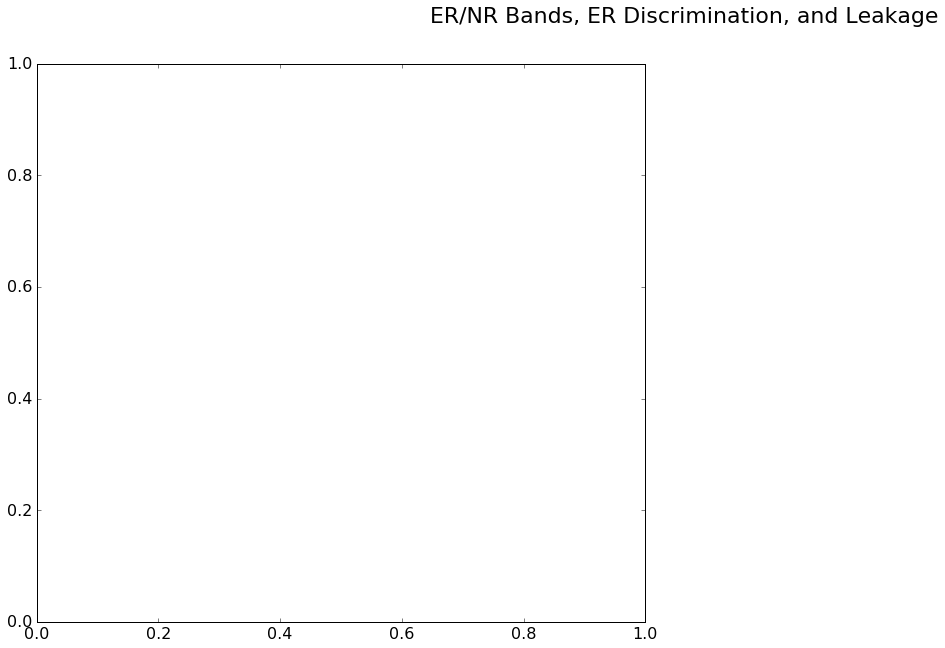

In [36]:
fig = plt.figure(figsize = (24,10))
plt.suptitle('ER/NR Bands, ER Discrimination, and Leakage', fontsize=22)

plt.subplot(121)
for i in range(len(dfs)):
    plt.plot(dfs[i].cs1, np.log10(dfs[i].cs2_bottom/dfs[i].cs1),'o',label=sources[i],alpha=0.3,markersize=4)
    
plt.plot(x,disc_99_fit,'k-',lw=3,label='99% ER Discrimination')
    
plt.xlim(0,200)
plt.xlabel('cs1 (PE)')
plt.ylabel('log10(cs2_bottom/cs1)')
plt.title('Recoil Bands, Low Energy Source Cuts')
plt.legend(markerscale=3)

plt.subplot(122)

# Calculate leakage ratios
cs1_lim, cs1_width = 200, 10
cs1_bins = int(cs1_lim/cs1_width)
leakage_ratios = []
for i in range(cs1_bins):
        
    # slice data in cs1
    cs1_min, cs1_max = i*cs1_width, (i+1)*cs1_width
    ratios = []
    for i in range(len(sources)):
        df_slice = cuts.selection(dfs[i], (dfs[i]['cs1'] > cs1_min) & (dfs[i]['cs1'] <= cs1_max), quiet=True)
        if i==0:
            df_slice_disc = cuts.selection(df_slice,df_slice['DISC'] < disc_exp(df_slice['cs1'],*disc_99_popt), quiet=True)
        else:
            df_slice_disc = cuts.selection(df_slice,df_slice['DISC'] > disc_exp(df_slice['cs1'],*disc_99_popt), quiet=True)
        ratios.append(len(df_slice_disc)/len(df_slice))
    leakage_ratios.append([np.mean([cs1_min,cs1_max]),ratios[0],ratios[1],ratios[2]])
leakage_ratios = np.array(leakage_ratios)

plt.plot(leakage_ratios[:,0],leakage_ratios[:,1],'-',lw=2,label='Rn220 in NR')
plt.plot(leakage_ratios[:,0],leakage_ratios[:,2],'-',lw=2,label='AmBe in ER')
plt.plot(leakage_ratios[:,0],leakage_ratios[:,3],'-',lw=2,label='NG in ER')

plt.xlabel('cs1 (PE)')
plt.ylabel('Leakage Fraction')
plt.legend(markerscale=3)
plt.title('Leakage Events')

plt.show()